Implement from scratch an RBM and apply it to DSET3. The RBM should be implemented fully by you (both CD-1 training and inference steps) but you are free to use library functions for the rest (e.g. image loading and management, etc.).

1.     Train an RBM with a number of hidden neurons selected by you (single layer) on the MNIST data (use the training set split provided by the website).

2.     Use the trained RBM to encode a selection of test images (e.g. using one per digit type) using the corresponding activation of the hidden neurons.

3.    Train a simple classifier (e.g. any simple classifier in scikit) to recognize the MNIST digits using as inputs their encoding obtained at step 2. Use the standard training/test split. Show a performance metric of your choice in the presentation/handout.

In [2]:
import keras
import tensorflow
import matplotlib.pyplot as plt
import numpy as np

In [3]:

from keras.datasets import mnist

(Xtr, ytr), (Xts, yts) = mnist.load_data()
     

In [4]:
Xtr_flat = Xtr.reshape(Xtr.shape[0],-1)
Xts_flat = Xts.reshape(Xts.shape[0],-1)
print(Xts_flat[0,300:350])

#i was having exploding gradient, so i normalized in this way
Xts_flat = Xts_flat / 255
Xtr_flat = Xtr_flat / 255



[254 106   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0  83 253 209  18   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


In [5]:
# RBM is composed by the nodes (hidden and visible) and the links between the nodes (the weights matrix) + bias
class RBM:
    def __init__(self, v_num, h_num):
        # number of visible variables
        self.v_num = v_num
        # number of hidden variables
        self.h_num = h_num
        # value of the weights
        self.weights = np.random.randn(v_num, h_num) * 0.1
        # bias
        self.v_bias = np.zeros(v_num)
        self.h_bias = np.zeros(h_num)

    def wake_phase(self, v_prob):
        # dot product between v_prob (which will be the data) and the weights, then add the bias
        h_activations = np.dot(v_prob, self.weights) + self.h_bias
        # compute activation
        h_probabilities = sigmoid(h_activations)
        return h_probabilities, np.random.binomial(1, h_probabilities)

    def dream_phase(self, h_prob):
        # dot product between h_prob and the transpose of the weights, then add the bias
        v_activations = np.dot(h_prob, self.weights.T) + self.v_bias
        # compute activation
        v_probabilities = sigmoid(v_activations)
        return v_probabilities, np.random.binomial(1, v_probabilities)

    # training cycle, inputs are: the dataset, the number of epochs, the batch size, the learning rate and the number of contrastive
    # divergence steps
    def train(self, data, num_epochs=10, batch_size=10, lr = 0.1, cd_steps = 1):

        num_examples = data.shape[0]

        for _ in range(num_epochs):
            # iterate starting from the first image on the entire dataset, moving the index according to batch_size
            for i in range(0, num_examples, batch_size):
                # i take 'batch_size' number of images
                batch = data[i:i + batch_size]

                # Contrastive divergence
                h_probabilities, h_active = self.wake_phase(batch)
                for _ in range(cd_steps):
                    _, reconstruction = self.dream_phase(h_active)
                    sampled_h_probabilities, sampled_h_active = self.wake_phase(reconstruction)

                # we try to reach equilibrium, so we want the difference to be closer as possible to zero
                visible_associations = np.dot(batch.T, h_probabilities)
                hidden_associations = np.dot(reconstruction.T, sampled_h_active)
                self.weights += lr * ((visible_associations - hidden_associations) / batch_size)
                self.v_bias += lr * np.mean(batch - reconstruction, axis=0)
                self.h_bias += lr * np.mean(h_probabilities - sampled_h_probabilities, axis=0)

    def generate(self, data):
        samples = np.copy(data)

        _ , hidden = self.wake_phase(samples)
        _ , visible = self.dream_phase(hidden)

        return visible


def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [12]:
from sklearn.metrics import mean_squared_error

# Initialize and train RBM
rbm = RBM(v_num=Xtr_flat.shape[1], h_num=50)
rbm.train(Xtr_flat, num_epochs=15,batch_size=64)

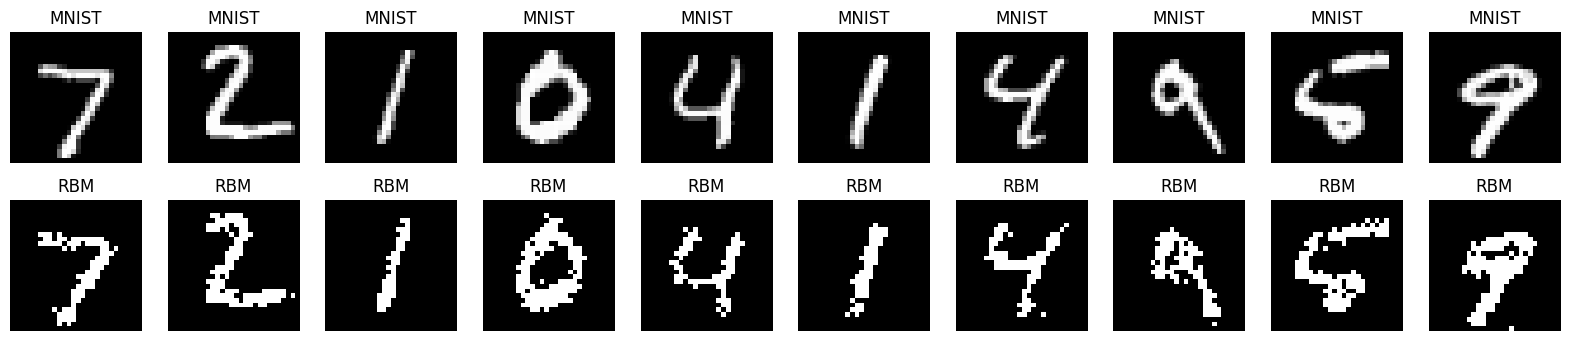

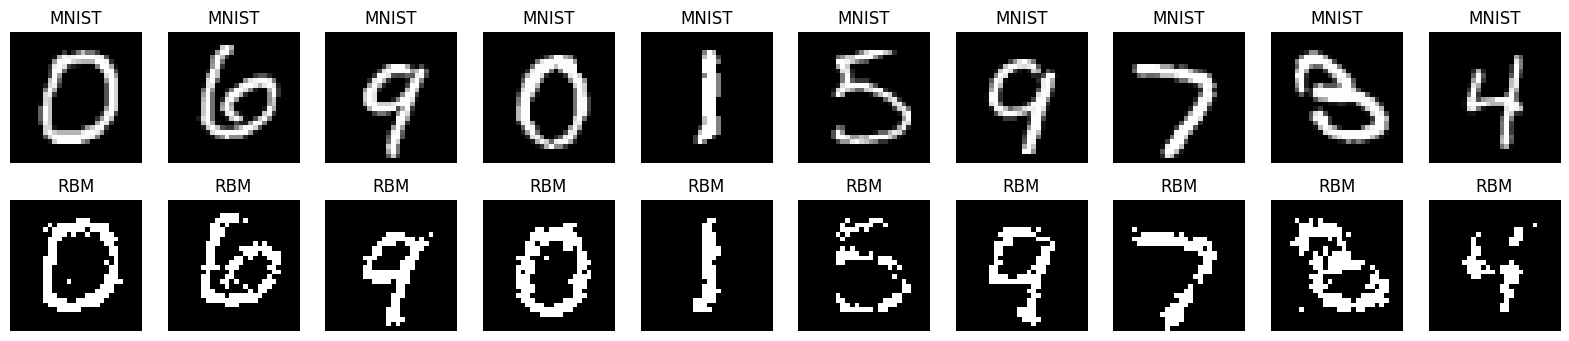

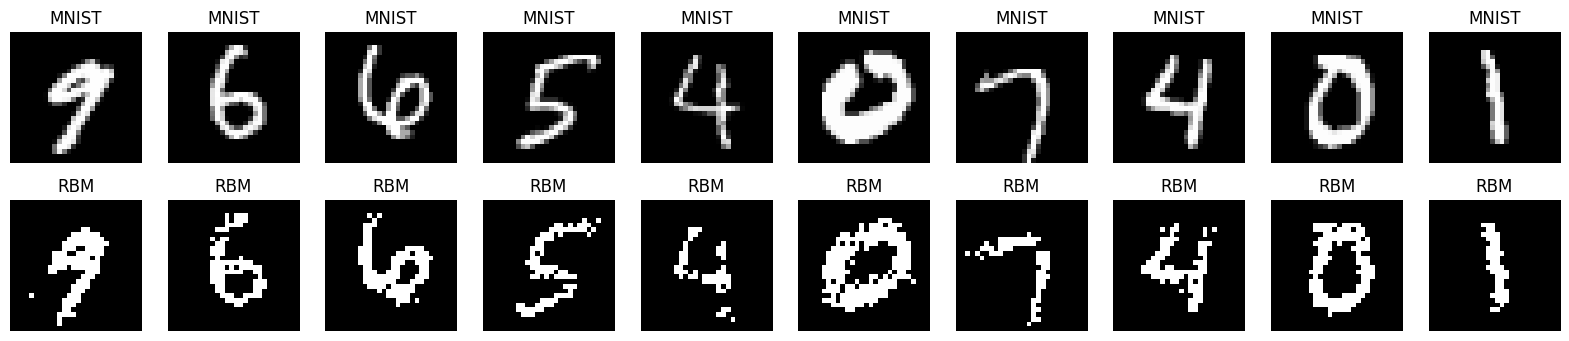

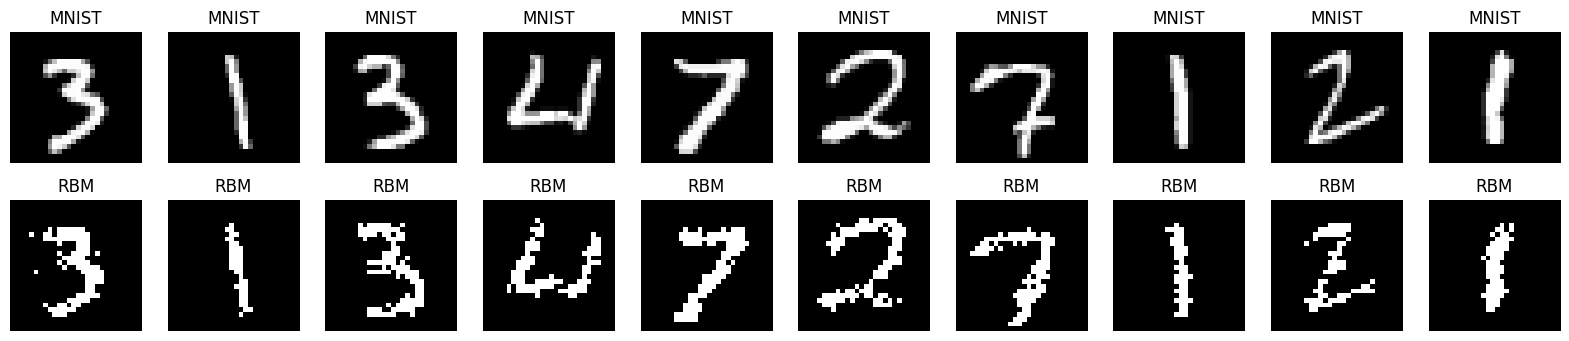

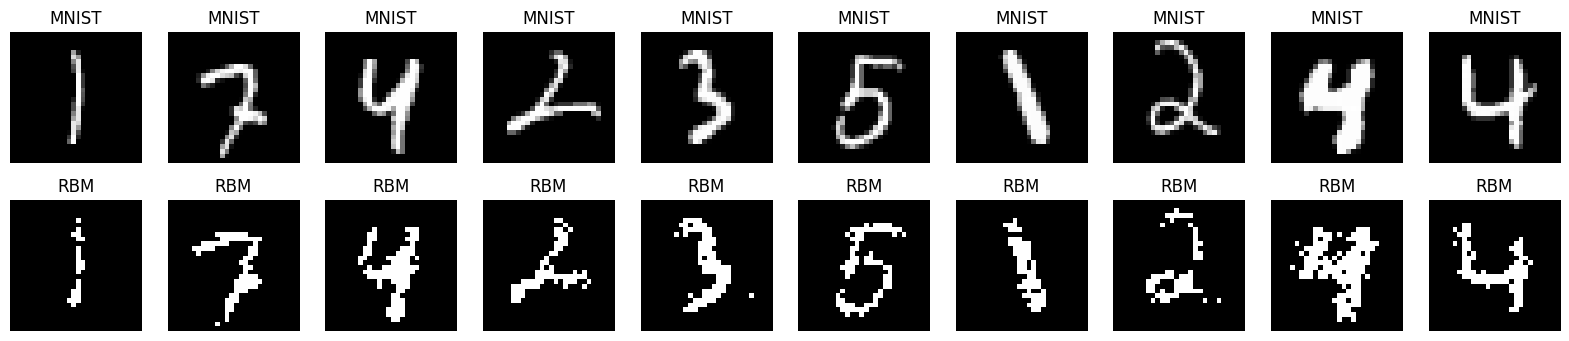

In [7]:
import numpy as np
import matplotlib.pyplot as plt

test_data = Xts_flat


def plot_images(original_images, reconstructed_images, num_images=10):
    plt.figure(figsize=(20, 4))
    for i in range(num_images):
        # Original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original_images[i].reshape(28, 28), cmap='gray')
        plt.title("MNIST")
        plt.axis('off')

        # Reconstructed image
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
        plt.title("RBM")
        plt.axis('off')
    plt.show()

# Assuming test_data contains original images and visible_prob contains reconstructions
num_images_to_plot = 50  # Number of images you want to plot

visible_prob= rbm.generate(test_data[:num_images_to_plot])

# Plot original and reconstructed images in cycles of 10, up to num_images_to_plot
for i in range(0, num_images_to_plot, 10):
    plot_images(test_data[i:i + 10], visible_prob[i:i + 10])

In [16]:
mean_squared_error(test_data,rbm.generate(test_data))

0.06517460521659581

In [17]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(80,40),
                    activation='tanh',
                    verbose=True,
                    validation_fraction=0.2,
                    n_iter_no_change=100,
                    learning_rate='adaptive')

# i take the activations of the wake phase (basically the encoded image)
mlp.fit(rbm.wake_phase(Xtr_flat)[0],ytr)

Iteration 1, loss = 0.72286417
Iteration 2, loss = 0.33831047
Iteration 3, loss = 0.29566454
Iteration 4, loss = 0.26847843
Iteration 5, loss = 0.24500524
Iteration 6, loss = 0.22810751
Iteration 7, loss = 0.21225192
Iteration 8, loss = 0.20055957
Iteration 9, loss = 0.19079720
Iteration 10, loss = 0.18134406
Iteration 11, loss = 0.17357444
Iteration 12, loss = 0.16742926
Iteration 13, loss = 0.16113609
Iteration 14, loss = 0.15557773
Iteration 15, loss = 0.15161271
Iteration 16, loss = 0.14694495
Iteration 17, loss = 0.14284781
Iteration 18, loss = 0.13970019
Iteration 19, loss = 0.13628921
Iteration 20, loss = 0.13324541
Iteration 21, loss = 0.13055236
Iteration 22, loss = 0.12726770
Iteration 23, loss = 0.12532805
Iteration 24, loss = 0.12373869
Iteration 25, loss = 0.12045446
Iteration 26, loss = 0.11906557
Iteration 27, loss = 0.11652158
Iteration 28, loss = 0.11474601
Iteration 29, loss = 0.11267244
Iteration 30, loss = 0.11198868
Iteration 31, loss = 0.10953020
Iteration 32, los

c:\Users\feder\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='tanh', hidden_layer_sizes=(80, 40),
              learning_rate='adaptive', n_iter_no_change=100,
              validation_fraction=0.2, verbose=True)

In [18]:
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
reconstruction = rbm.wake_phase(test_data)[0]
print(reconstruction.shape)
predictions_mlp = mlp.predict(reconstruction)

(10000, 50)


50
28
[[-0.3465916  -0.30161454 -0.52759439 -0.39344728 -0.13245539 -0.55231232
  -0.49144351 -0.48495698 -0.39536358 -0.37474609 -0.44087906 -0.16650965
  -0.15938635 -0.48366768 -0.00767343 -0.23021424 -0.30579885 -0.18216902
  -0.53710624 -0.46924608 -0.32048059 -0.18432687 -0.52013367 -0.51354721
  -0.30158469 -0.43448247 -0.35575187 -0.21305455]
 [-0.47196412 -0.50095487 -0.02813159 -0.33895358 -0.61794533 -0.38175532
  -0.51102402 -0.54250663 -0.48115264 -0.40426758 -0.31222566 -0.22747583
  -0.40221179 -0.54748165 -0.51487102 -0.11655847 -0.29732476 -0.28549116
  -0.29264019 -0.33427719 -0.22206741 -0.36413252 -0.34414917 -0.10584877
  -0.37695936 -0.42215022 -0.23024148 -0.64763116]
 [-0.64031826 -0.46606181 -0.34202687 -0.62147242 -0.3045174  -0.07620182
  -0.1697208  -0.34094571 -0.1602674  -0.28504669 -0.41092528 -0.40186932
  -0.38128969 -0.39504421 -0.28328007 -0.08515951 -0.38864268 -0.3651604
  -0.44814665 -0.56681108 -0.26707    -0.24151419 -0.40771161 -0.53286731
   0.

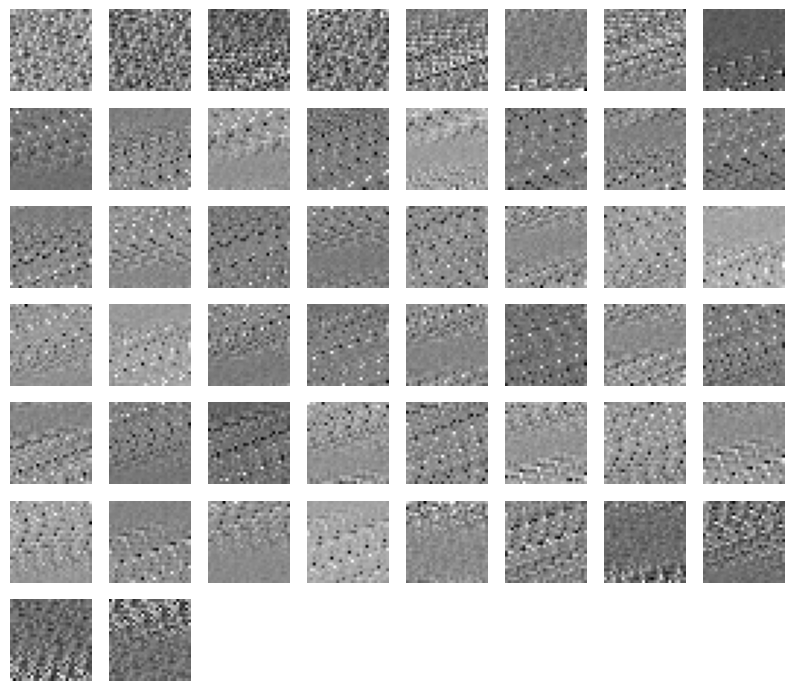

In [15]:

num_filters = rbm.weights.shape[1]
print(num_filters)
filter_size = int(np.sqrt(rbm.weights.shape[0]))
print(filter_size)
filters = rbm.weights.reshape(num_filters, filter_size, filter_size)
print(filters[1])
# Plot the filters
plt.figure(figsize=(10, 10))
for i in range(num_filters):
    plt.subplot(8, 8, i + 1)
    plt.imshow(filters[i], cmap='gray')
    plt.axis('off')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

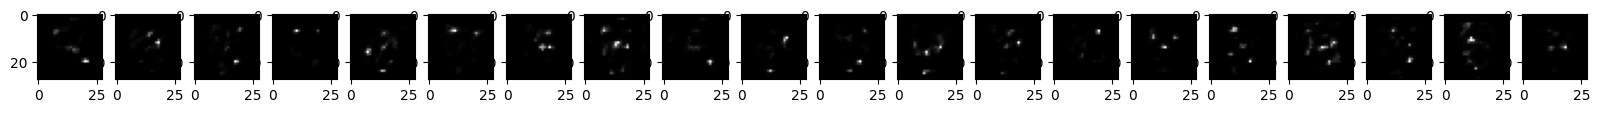

In [ ]:
import matplotlib.pyplot as plt

plots = []

sample = np.zeros(784)

for i in range(1000):
    _ , hidden = rbm.wake_phase(sample)
    probs , visible = rbm.dream_phase(hidden)
    plots.append(probs)
    sample = probs

plt.figure(figsize=(20, 4))
for i in range(20): 
    plt.subplot(2, 20, i + 1 + 20)
    plt.imshow(plots[999-i].reshape(28, 28), cmap='gray')
plt.show

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       980
           1       0.99      0.99      0.99      1135
           2       0.95      0.95      0.95      1032
           3       0.91      0.92      0.91      1010
           4       0.96      0.93      0.94       982
           5       0.93      0.91      0.92       892
           6       0.96      0.96      0.96       958
           7       0.95      0.93      0.94      1028
           8       0.93      0.93      0.93       974
           9       0.90      0.93      0.91      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000

Strato 1: 80 nodi
Strato 2: 40 nodi


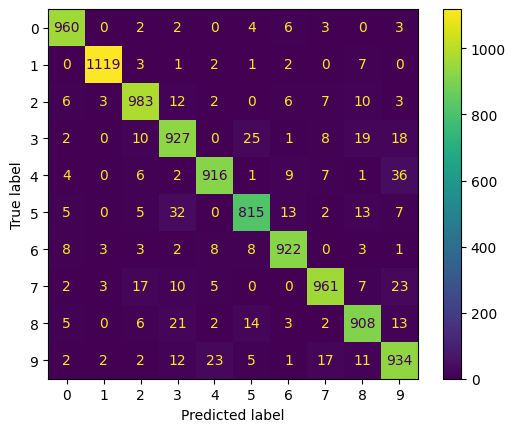

In [19]:
print(classification_report(yts,predictions_mlp))
for i, num_nodi in enumerate(mlp.hidden_layer_sizes):
    print(f"Strato {i + 1}: {num_nodi} nodi")
matrix = confusion_matrix(yts,predictions_mlp,labels=[0,1,2,3,4,5,6,7,8,9])

disp = ConfusionMatrixDisplay(confusion_matrix=matrix,
                            display_labels=mlp.classes_)
disp.plot()

plt.show()

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(80,40),
                    activation='tanh',
                    verbose=True,
                    validation_fraction=0.2,
                    n_iter_no_change=100)

mlp.fit(Xtr_flat,ytr)

predictions_true_mlp = mlp.predict(Xts_flat)

print(classification_report(yts,predictions_true_mlp))


Iteration 1, loss = 0.46976350
Iteration 2, loss = 0.21211986
Iteration 3, loss = 0.15567083
Iteration 4, loss = 0.12064898
Iteration 5, loss = 0.09640578
Iteration 6, loss = 0.07952202
Iteration 7, loss = 0.06581748
Iteration 8, loss = 0.05573582
Iteration 9, loss = 0.04723939
Iteration 10, loss = 0.04053318
Iteration 11, loss = 0.03513863
Iteration 12, loss = 0.02919901
Iteration 13, loss = 0.02528486
Iteration 14, loss = 0.02107163
Iteration 15, loss = 0.01822270
Iteration 16, loss = 0.01512481
Iteration 17, loss = 0.01308860
Iteration 18, loss = 0.01088731
Iteration 19, loss = 0.00905793
Iteration 20, loss = 0.00796301
Iteration 21, loss = 0.00623360
Iteration 22, loss = 0.00699309
Iteration 23, loss = 0.00737581
Iteration 24, loss = 0.00592491
Iteration 25, loss = 0.00767853
Iteration 26, loss = 0.00416477
Iteration 27, loss = 0.00232820
Iteration 28, loss = 0.00162625
Iteration 29, loss = 0.00136236
Iteration 30, loss = 0.00126315
Iteration 31, loss = 0.00111494
Iteration 32, los